In [2]:
# Select algorithm to use as machine learner
# 0 = Linear Regression
# 1 = SVR  (not recommended - too slow)
# 2 = Decision Tree
# 3 = Random Forest
# 4 = XGBoost

algorithm_choice = 3

#Check a valid choice of algorithm has been made
assert algorithm_choice in [0,1,2,3,4]

In [3]:
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import numpy as np
from nltk.stem import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print "Import successful"

Import successful


C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [4]:
try:
    data = pd.read_csv("train.csv")
    
    print "Quora duplicate questions training dataset has {} samples with {} features each.".format(*data.shape)
    
except:
    print "Dataset(s) could not be loaded. Please check filename is correct and dataset exists"

Quora duplicate questions training dataset has 404290 samples with 6 features each.


In [5]:
print "Display sample of training data:"
display(data.head(10))

Display sample of training data:


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [6]:
print "Display statistics about training data:"
display(data.describe())

Display statistics about training data:


,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [7]:
#question ids not useful information
data.drop(['id', 'qid1', 'qid2'], axis = 1, inplace = True)

#data.dropna(how = "any", axis = 0, inplace = True)
data.fillna(value = "", axis = 0, inplace = True)

print "Modified Quora duplicate questions training dataset has {} samples with {} features each.".format(*data.shape)

#split into features and results
results = data['is_duplicate']
features_raw = data.drop('is_duplicate', axis = 1)

#check training features and results are as expected
display(results.head(10))
display(features_raw.head(10))

Modified Quora duplicate questions training dataset has 404290 samples with 3 features each.


0    0
1    0
2    0
3    0
4    0
5    1
6    0
7    1
8    0
9    0
Name: is_duplicate, dtype: int64

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan..."
6,Should I buy tiago?,What keeps childern active and far from phone ...
7,How can I be a good geologist?,What should I do to be a great geologist?
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?"
9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?


In [8]:
from sklearn.feature_extraction import stop_words

def remove_stop_words(x):
    """Preprocess text to remove 'stopwords' from it (common words with little useful information)"""
    try:
        original_words = x.split()
        output = " "

        for word in original_words:
            if not word in stop_words.ENGLISH_STOP_WORDS:
                output += word + " "

        return output[:-1]
    except: #for the case of NaN entries
        return ""

In [9]:
#Test that the remove_stop_words function works as expected
print remove_stop_words("Say hello to the cat")
print remove_stop_words("I am six years old")

 Say hello cat
 I years old


In [10]:
def to_lower_case(x):
    """Convert all text to lowercase"""
    try:
        return x.lower()
    except:
        return ""

In [11]:
import string

def strip_punctuation(x):
    """Remove all special punctuation characters"""
    try:
        return x.translate(None, string.punctuation)
    except:
        return ""

In [12]:
#Test strip_punctuation()
print string.punctuation
print strip_punctuation("This. is! my STring.... :)")

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
This is my STring 


In [13]:
#Reference - http://www.nltk.org/howto/stem.html

stemmer = SnowballStemmer("english")

def stem_words(x):
    """Preprocess text to stem all words (e.g. remove plurals, verb ending, etc)"""
    try:
        original_words = x.split()
        output = " "

        for word in original_words:
            output += stemmer.stem(word) + " "

        return output[:-1]
    except: #for the case of NaN entries
        return ""
    

In [14]:
test_words = ["hello", "running", "forgotten", "turned", "turns", "turning"]

for w in test_words:
    print(stemmer.stem(w))
    
test_sentence = "I am returning from running to the park after I ate some sandwiches quickly"
print stem_words(test_sentence)

hello
run
forgotten
turn
turn
turn
 i am return from run to the park after i ate some sandwich quick


In [15]:
### Data pre-processing ###

display(features_raw.head(10))

#Make all text lower case
features_raw["question1"] = features_raw["question1"].apply(to_lower_case)
features_raw["question2"] = features_raw["question2"].apply(to_lower_case)

#Remove stopwords
features_raw["question1"] = features_raw["question1"].apply(remove_stop_words)
features_raw["question2"] = features_raw["question2"].apply(remove_stop_words)

#Stem all words
features_raw["question1"] = features_raw["question1"].apply(stem_words)
features_raw["question2"] = features_raw["question2"].apply(stem_words)

display(features_raw.head(10))

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan..."
6,Should I buy tiago?,What keeps childern active and far from phone ...
7,How can I be a good geologist?,What should I do to be a great geologist?
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?"
9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?


,question1,question2
0,step step guid invest share market india?,step step guid invest share market?
1,stori kohinoor (koh-i-noor) diamond?,happen indian govern stole kohinoor (koh-i-no...
2,increas speed internet connect use vpn?,internet speed increas hack dns?
3,mental lonely? solv it?,"remaind [math]23^{24}[/math] divid 24,23?"
4,"dissolv water quik sugar, salt, methan carbon...",fish surviv salt water?
5,astrology: capricorn sun cap moon cap rising....,"i'm tripl capricorn (sun, moon ascend caprico..."
6,buy tiago?,keep childern activ far phone video games?
7,good geologist?,great geologist?
8,,"use ""&"" instead ""and""?"
9,motorola (company): hack charter motorolla dc...,hack motorola dcx3400 free internet?


In [16]:
def diff_num_chars(x):
    """Create new feature - return the absolute difference in length of both questions, in terms of total number of chars"""
    try:
        len1 = len(x["question1"])
        len2 = len(x["question2"])
        return np.absolute(len1 - len2)
    except:
        print x["question1"]    #print unexpected output for debug
        print x["question2"]
        return 500 #penalty diff num chars

In [17]:
def diff_num_words(x):
    """Create new feature - return the absolute difference in length of both questions, in terms of total number of words"""
    try:
        len1 = len(x["question1"].split())
        len2 = len(x["question2"].split())
        return np.absolute(len1 - len2)
    except:
        print x["question1"]   #print unexpected output for debug
        print x["question2"]
        return 100 #penalty diff num words

In [18]:
def num_common_words(x):
    """Create new feature - return the number of common words between both questions"""
    try:
        words1 = x["question1"].split()
        words2 = x["question2"].split()
        
        common_words = 0
        
        for word in words1:
            word_l = word
            if word in words2:
                common_words += 1
                
        return common_words
        
    except:
        print x["question1"]  #print unexpected output for debug
        print x["question2"]
        return 0

In [19]:
def ratio_common_words(x):
    """Create new feature - return ratio of common words between both questions"""
    try:
        return 1.0 * num_common_words(x) / (len(x["question1"].split()) + len(x["question2"].split()))
    except:
        return 0

In [20]:
features = pd.DataFrame()
features["diff_num_chars"] = features_raw.apply(diff_num_chars, axis=1)
features["diff_num_words"] = features_raw.apply(diff_num_words, axis=1)
features["num_common_words"] = features_raw.apply(num_common_words, axis=1)
features["ratio_common_words"] = features_raw.apply(ratio_common_words, axis=1)
display(features.head(10))

,diff_num_chars,diff_num_words,num_common_words,ratio_common_words
0,6,1,5,0.384615
1,26,4,2,0.166667
2,7,1,3,0.272727
3,18,0,0,0.000000
4,32,5,0,0.000000
5,3,0,5,0.250000
6,32,5,0,0.000000
7,1,0,1,0.250000
8,23,4,0,0.000000
9,15,1,2,0.181818


In [21]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
feature_list = ["diff_num_chars", "diff_num_words", "num_common_words", "ratio_common_words"]

scaled_data = min_max_scaler.fit_transform(features[feature_list])

features_scaled = pd.DataFrame(data = scaled_data, columns=feature_list)
display(features_scaled.head())
#display(test)

,diff_num_chars,diff_num_words,num_common_words,ratio_common_words
0,0.010187,0.01,0.20,0.576923
1,0.044143,0.04,0.08,0.250000
2,0.011885,0.01,0.12,0.409091
3,0.030560,0.00,0.00,0.000000
4,0.054329,0.05,0.00,0.000000


In [22]:
from sklearn.cross_validation import train_test_split

#Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, results, test_size = 0.2, random_state = 17)

print "Training and testing split was successful."

Training and testing split was successful.


C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family [u'STIXGeneral'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1298: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning C:\WINDOWS\Fonts\GOTHICB.TTF
  UserWarning)
C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family [u'STIXSizeOneSym'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1298: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal

C:\Users\amalpass\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family [u'cmss10'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


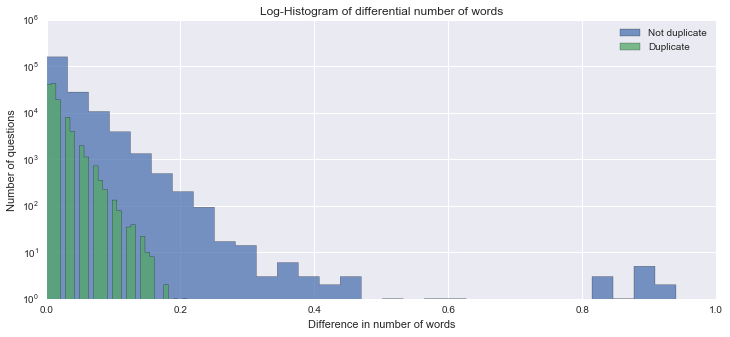

In [23]:
### Visualisation - plot histogram showing how distrubtion of differential number of words between both questions
### varies between duplicate and non-duplicate questions ###

# Histogram plotting techniques inspired by:
# https://www.kaggle.com/anokas/quora-question-pairs/data-analysis-xgboost-starter-0-35460-lb

plt.figure(figsize=(12, 5))
plt.hist(X_train["diff_num_words"][y_train == 0], bins=30, histtype="stepfilled", alpha = 0.75, label="Not duplicate")
plt.hist(X_train["diff_num_words"][y_train == 1], bins=30, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of differential number of words')
plt.xlabel('Difference in number of words')
plt.ylabel('Number of questions')
plt.legend()
print

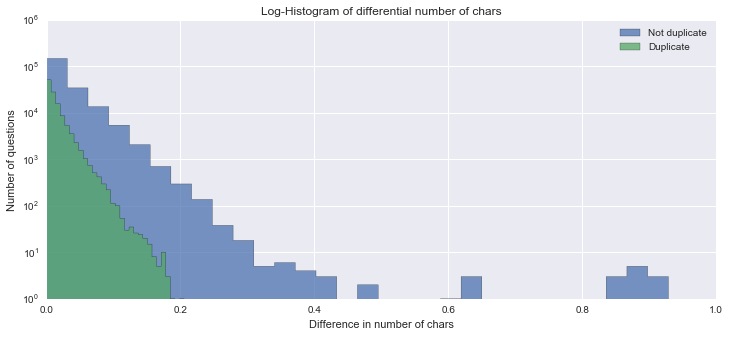

In [24]:
### Visualisation - plot histogram showing how distrubtion of differential number of chars between both questions
### varies between duplicate and non-duplicate questions ###

plt.figure(figsize=(12, 5))
plt.hist(X_train["diff_num_chars"][y_train == 0], bins=30, histtype="stepfilled", alpha = 0.75,label= "Not duplicate")
plt.hist(X_train["diff_num_chars"][y_train == 1], bins=30, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of differential number of chars')
plt.xlabel('Difference in number of chars')
plt.ylabel('Number of questions')
plt.legend()
print

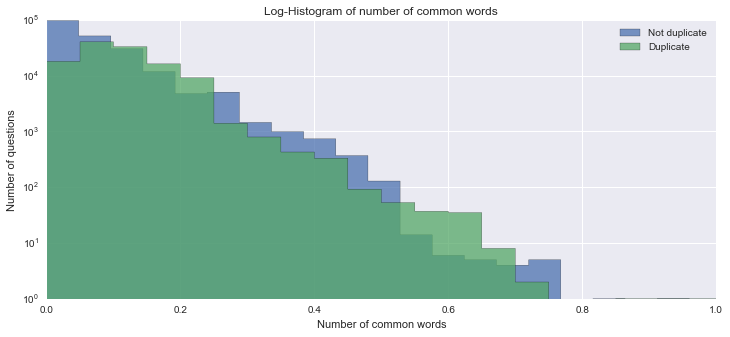

In [25]:
### Visualisation - plot histogram showing how distrubtion of number of common words between both questions
### varies between duplicate and non-duplicate questions ###

plt.figure(figsize=(12, 5))
plt.hist(X_train["num_common_words"][y_train == 0], bins=20, histtype="stepfilled", alpha = 0.75, label="Not duplicate")
plt.hist(X_train["num_common_words"][y_train == 1], bins=20, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of number of common words')
plt.xlabel('Number of common words')
plt.ylabel('Number of questions')
plt.legend()
print

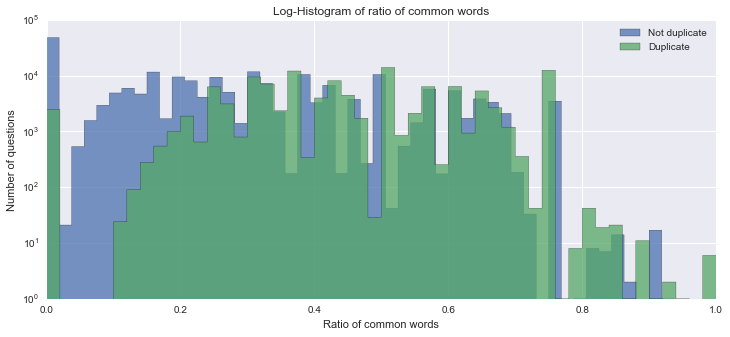

In [26]:
### Visualisation - plot histogram showing how distrubtion of ratio of common words between both questions
### varies between duplicate and non-duplicate questions ###

plt.figure(figsize=(12, 5))
plt.hist(X_train["ratio_common_words"][y_train == 0], bins=50, histtype="stepfilled", alpha = 0.75, label="Not duplicate")
plt.hist(X_train["ratio_common_words"][y_train == 1], bins=50, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of ratio of common words')
plt.xlabel('Ratio of common words')
plt.ylabel('Number of questions')
plt.legend()
print

In [26]:
from sklearn.metrics import log_loss

def performance_metric(y_true, y_predict):
    """ Calculate and return the performance score between true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'  
    score = log_loss(y_true, y_predict)
    #print score
    
    # Return the score
    return score

In [27]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y):
    """ Perform grid search over the 'max_depth' parameter for a decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    print "DEBUG - making cv_sets"
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    

    print "DEBUG - making regressor"
    
    if algorithm_choice == 0:    #Linear Regression
        regressor = LinearRegression()
        params = {'fit_intercept':(True, False)}
        
    elif algorithm_choice == 1:  #SVR
        regressor = svm.SVR()
        params = {'C': (1,10)}
        
    elif algorithm_choice == 2:  #Decision Tree
        regressor = DecisionTreeRegressor()
        params = {'max_depth':(10, None)}
        
    elif algorithm_choice == 3:  #Random Forest
        regressor = RandomForestRegressor(n_estimators = 20)
        params = {'max_depth':(10, None)}
        #params = {'max_depth':(2,5,10, None), 'min_samples_split':(1,2,3,4)} 
          

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    print "DEBUG - making scorer"
    scoring_fnc = make_scorer(performance_metric)
    
    print "DEBUG - starting gridsearch"
    # Create the grid search object
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets, verbose = 1)

    print "DEBUG - finished gridsearch, starting fit"
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    print "DEBUG - finished fit"

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [28]:
#Remove unnecessary feature
X_train.drop(["diff_num_chars"], axis = 1, inplace = True)
X_test.drop(["diff_num_chars"], axis = 1, inplace = True)
X_train.drop(["num_common_words"], axis = 1, inplace = True)
X_test.drop(["num_common_words"], axis = 1, inplace = True)
print "Removed unwanted features"

/Users/Adam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Adam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Adam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Removed unwanted features


/Users/Adam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
if algorithm_choice != 4: #calculate test predictions (in case of any algorithms except XGBoost)

    # Fit the training data to the model using grid search

    print "DEBUG - calling fit_model"
    reg = fit_model(X_train, y_train)

    # Print the optimal model parameters
    #print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])
    print "Optimal model parameters: ", reg.get_params()
    
else:
    print "Skipping since using XGBoost"

DEBUG - calling fit_model
DEBUG - making cv_sets
DEBUG - making regressor
DEBUG - making scorer
DEBUG - starting gridsearch
DEBUG - finished gridsearch, starting fit
Fitting 10 folds for each of 2 candidates, totalling 20 fits
DEBUG - finished fit
Optimal model parameters:  {'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'max_features': 'auto', 'max_depth': None}


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   33.4s finished


In [30]:
if algorithm_choice != 4: #calculate test predictions (in case of any algorithms except XGBoost)
    display(X_test.head(10))
    preds_train = reg.predict(X_train)
    preds_test = reg.predict(X_test)
    #display(preds_train[:10])
    
    score_train = performance_metric(y_train, preds_train)
    score_test = performance_metric(y_test, preds_test)

    print "Score on training set:", score_train
    print "Score on testing set:", score_test
else:
    print "Skipping since using XGBoost"

,diff_num_words,ratio_common_words
225143,0.02,0.187500
162274,0.00,0.187500
217127,0.04,0.000000
394527,0.01,0.428571
55570,0.00,0.375000
67848,0.00,0.656250
325138,0.00,0.375000
146588,0.00,0.000000
236711,0.00,0.750000
211378,0.01,0.666667


Score on training set: 0.500634573653
Score on testing set: 0.510979528781


In [ ]:
import xgboost as xgb

if algorithm_choice == 4: #XGBoost

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = 0.02
    params['max_depth'] = 4

    d_train = xgb.DMatrix(X_train, label=y_train)
    d_valid = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

else:
    print "Skipping since not using XGBoost"


In [ ]:
#Load the competition testing data set

try:
    test_data = pd.read_csv("test.csv")
    
    print "Quora duplicate questions competion test dataset has {} samples with {} features each.".format(*test_data.shape)
    
except:
    print "Dataset(s) could not be loaded. Please check filename is correct and dataset exists"

In [ ]:
#Pre-process competition test data in same was as training data
display(test_data.head())

test_data.fillna(value = "", axis = 0, inplace = True)

#Make all text lower case
test_data["question1"] = test_data["question1"].apply(to_lower_case)
test_data["question2"] = test_data["question2"].apply(to_lower_case)

#Remove stop words
test_data["question1"] = test_data["question1"].apply(remove_stop_words)
test_data["question2"] = test_data["question2"].apply(remove_stop_words)

#Stem all words
test_data["question1"] = test_data["question1"].apply(stem_words)
test_data["question2"] = test_data["question2"].apply(stem_words)

test_data_features = pd.DataFrame()
test_data_features["diff_num_chars"] = test_data.apply(diff_num_chars, axis=1)
test_data_features["diff_num_words"] = test_data.apply(diff_num_words, axis=1)
test_data_features["num_common_words"] = test_data.apply(num_common_words, axis=1)
test_data_features["ratio_common_words"] = test_data.apply(ratio_common_words, axis=1)

display(test_data_features.head())

#min_max_scaler = preprocessing.MinMaxScaler()
feature_list = ["diff_num_chars", "diff_num_words", "num_common_words", "ratio_common_words"]

test_scaled_data = min_max_scaler.transform(test_data_features[feature_list])

test_features_scaled = pd.DataFrame(data = test_scaled_data, columns=feature_list)
display(test_features_scaled.head())

In [ ]:
#Remove unnecessary feature
#test_data_features.drop(["diff_num_chars"], axis = 1, inplace = True)
#test_data_features.drop(["num_common_words"], axis = 1, inplace = True)
test_features_scaled.drop(["diff_num_chars"], axis = 1, inplace = True)
test_features_scaled.drop(["num_common_words"], axis = 1, inplace = True)
print "Removed unwanted features"

In [ ]:
if algorithm_choice == 4: #XGBoost
    d_test = xgb.DMatrix(test_features_scaled)
    #d_test = xgb.DMatrix(test_data_features)
    test_predictions = bst.predict(d_test)
else:  #Scikit-learn
    test_predictions = reg.predict(test_features_scaled)
    #test_predictions = reg.predict(test_features_scaled)

#print "Test_data_features shape: ", test_data_features.shape
#print "Test_predictions shape: ", test_predictions.shape
final_output = pd.concat([test_data["test_id"], pd.Series(test_predictions, name = "is_duplicate")], axis=1)

#print "Final output has {} samples with {} features each.".format(*final_output.shape)

display(final_output.head())

In [ ]:
final_output.to_csv("final_output.csv", index = False)
print "Final predictions written to final_output.csv successfully"